In [ ]:
Name = 'Parsa Ghezelbash'
STID = 401110437

In [2]:
import numpy as np



import matplotlib.pyplot as plt







import torch



import torch.nn as nn



import torch.nn.functional as F



import torch.optim as optim



from torch.utils.data import Subset



from torch.utils.data import DataLoader



from torch.utils.data import random_split







import torchvision



import torchvision.transforms as transforms



from torchvision.models import (



    resnet50,



    ResNet50_Weights,



    mobilenet_v2,



    MobileNet_V2_Weights,



    vgg16,



    VGG16_Weights,



)







from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



from sklearn.preprocessing import OneHotEncoder







from PIL import Image



import requests



from io import BytesIO









import time







import importlib



import utils







importlib.reload(utils)



from utils.utils import (



    accuracy,



    train,



    combined_train,



    test,



    combined_test,



    plot_acc,



    plot_loss,



    plot_confusion_matrix,



    save_model,



    get_feature_maps,



    visualize_feature_maps,



    plot_images,



    plot_feature_maps,



    get_num_parameters,



)

In [3]:
num_classes = 102



torch.manual_seed(13)



np.random.seed(13)







mean = [0.485, 0.456, 0.406]



std = [0.229, 0.224, 0.225]



image_size = (224, 224)



batch_size = 32

# Loading Flower102 + Preprocess

In [4]:
train_transform = transforms.Compose(



    [



        transforms.Resize(size=(256, 256)),



        transforms.RandomCrop(size=image_size),



        transforms.RandomHorizontalFlip(),



        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),



        transforms.ToTensor(),



        transforms.Normalize(mean=mean, std=std),



    ]



)







val_transform = transforms.Compose(



    [



        transforms.Resize(size=image_size),



        transforms.ToTensor(),



        transforms.Normalize(mean=mean, std=std),



    ]



)

In [5]:
train_dataset = torchvision.datasets.Flowers102(



    root="./data",



    split="test",



    download=True,



    transform=train_transform,



)







val_dataset = torchvision.datasets.Flowers102(



    root="./data",



    split="val",



    download=True,



    transform=val_transform,



)







test_dataset = torchvision.datasets.Flowers102(



    root="./data",



    split="train",



    download=True,



    transform=val_transform,



)







print(f"Train Dataset: {len(train_dataset)}")



print(f"Val Dataset: {len(val_dataset)}")



print(f"Test Dataset: {len(test_dataset)}")

100%|██████████| 344862509/344862509 [00:24<00:00, 13878346.63it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 381300.36it/s]


100%|██████████| 14989/14989 [00:00<00:00, 8543065.99it/s]

Train Dataset: 6149
Val Dataset: 1020
Test Dataset: 1020


In [6]:
train_loader = DataLoader(



    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True



)



val_loader = DataLoader(



    val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True



)



test_loader = DataLoader(



    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True



)

In [7]:
url = "https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt"

response = requests.get(url)

if response.status_code == 200:

    lines = response.text.splitlines()

    

    processed_lines = [line.strip().strip("'").strip("\"") for line in lines]

else:

    print(f"Failed to fetch the file. Status code: {response.status_code}")





classes = np.array(processed_lines)

print(classes)

['pink primrose' 'hard-leaved pocket orchid' 'canterbury bells'
 'sweet pea' 'english marigold' 'tiger lily' 'moon orchid'
 'bird of paradise' 'monkshood' 'globe thistle' 'snapdragon' "colt's foot"
 'king protea' 'spear thistle' 'yellow iris' 'globe-flower'
 'purple coneflower' 'peruvian lily' 'balloon flower'
 'giant white arum lily' 'fire lily' 'pincushion flower' 'fritillary'
 'red ginger' 'grape hyacinth' 'corn poppy' 'prince of wales feathers'
 'stemless gentian' 'artichoke' 'sweet william' 'carnation' 'garden phlox'
 'love in the mist' 'mexican aster' 'alpine sea holly'
 'ruby-lipped cattleya' 'cape flower' 'great masterwort' 'siam tulip'
 'lenten rose' 'barbeton daisy' 'daffodil' 'sword lily' 'poinsettia'
 'bolero deep blue' 'wallflower' 'marigold' 'buttercup' 'oxeye daisy'
 'common dandelion' 'petunia' 'wild pansy' 'primula' 'sunflower'
 'pelargonium' 'bishop of llandaff' 'gaura' 'geranium' 'orange dahlia'
 'pink-yellow dahlia?' 'cautleya spicata' 'japanese anemone'
 'black-eye

In [8]:
unique, counts = np.unique(train_dataset._labels, return_counts=True)



class_weights = 1 / counts



class_weights /= class_weights.sum()



class_weights = torch.tensor(class_weights).float()



print(class_weights)

tensor([0.0201, 0.0100, 0.0201, 0.0112, 0.0089, 0.0161, 0.0201, 0.0062, 0.0155,
        0.0161, 0.0060, 0.0060, 0.0139, 0.0143, 0.0139, 0.0191, 0.0062, 0.0065,
        0.0139, 0.0112, 0.0201, 0.0103, 0.0057, 0.0183, 0.0191, 0.0191, 0.0201,
        0.0087, 0.0069, 0.0062, 0.0126, 0.0161, 0.0155, 0.0201, 0.0175, 0.0073,
        0.0046, 0.0112, 0.0191, 0.0085, 0.0038, 0.0103, 0.0037, 0.0055, 0.0201,
        0.0023, 0.0085, 0.0079, 0.0139, 0.0056, 0.0017, 0.0062, 0.0055, 0.0098,
        0.0079, 0.0045, 0.0085, 0.0043, 0.0085, 0.0045, 0.0134, 0.0115, 0.0118,
        0.0126, 0.0049, 0.0098, 0.0183, 0.0118, 0.0118, 0.0096, 0.0069, 0.0053,
        0.0023, 0.0027, 0.0040, 0.0046, 0.0017, 0.0034, 0.0191, 0.0047, 0.0028,
        0.0044, 0.0036, 0.0061, 0.0093, 0.0106, 0.0093, 0.0030, 0.0024, 0.0065,
        0.0072, 0.0087, 0.0155, 0.0028, 0.0037, 0.0057, 0.0087, 0.0065, 0.0093,
        0.0139, 0.0106, 0.0143])


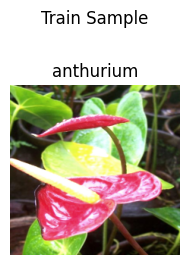

In [9]:
images, labels = next(iter(train_loader))



plot_images([images[0]], mean, std, [classes[labels[0]]], "Train Sample")

# Loading MobileNet V2 + Sample Image

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print(f"device: {device.type}")

device: cuda


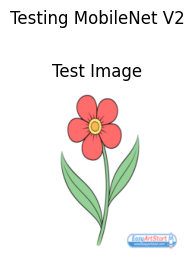

In [11]:
url = "https://www.easyartstart.com/wp-content/uploads/2024/04/flower_drawing.png"

response = requests.get(url)

if response.status_code == 200:

    test_image = Image.open(BytesIO(response.content))

else:

    print("Failed to retrieve the image.")



test_image = val_transform(test_image).unsqueeze(0)



test_image.shape



plot_images(test_image, mean, std, ["Test Image"], title="Testing MobileNet V2")

## Testing an Image on MobileNet V2

In [12]:
mobilenet_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)



mobilenet_model.classifier

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 109MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
mobilenet_model.to(device)



test_image = test_image.to(device)



mobilenet_model.eval()







test_output = mobilenet_model(test_image)



top_classes, top_classes_idx = torch.topk(test_output, k=3, dim=1)



top_classes, top_classes_idx = top_classes.squeeze(), top_classes_idx.squeeze()



top_classes, top_classes_idx

(tensor([4.7010, 4.2780, 4.1798], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([584, 723, 549], device='cuda:0'))

In [14]:
mobilenet_categories = np.array(MobileNet_V2_Weights.DEFAULT.meta["categories"])



top_categories = mobilenet_categories[top_classes_idx.cpu()]



print(f"Top 3 categories: {top_categories}")

Top 3 categories: ['hair slide' 'pinwheel' 'envelope']


# Preparing and Training MobileNet V2 for Classification on Flower102 Dataset

In [15]:
num_features = mobilenet_model.classifier[1].in_features



mobilenet_model.classifier[1] = nn.Linear(



    in_features=num_features, out_features=num_classes, bias=True



)







for param in mobilenet_model.parameters():



    param.requires_grad = False







for param in mobilenet_model.classifier.parameters():



    param.requires_grad = True

In [16]:
mobilenet_model.to(device)



class_weights = class_weights.to(device)



criterion = nn.CrossEntropyLoss(weight=class_weights)



optimizer = optim.Adam(mobilenet_model.classifier.parameters())

In [17]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=mobilenet_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 17.441, Train acc: 0.905, Val loss: 20.212, Val acc: 0.91
Epoch 10/30, Train loss: 8.955, Train acc: 0.939, Val loss: 14.25, Val acc: 0.918
Epoch 15/30, Train loss: 6.251, Train acc: 0.951, Val loss: 13.075, Val acc: 0.92
Epoch 20/30, Train loss: 4.724, Train acc: 0.962, Val loss: 12.058, Val acc: 0.928
Epoch 25/30, Train loss: 3.856, Train acc: 0.966, Val loss: 11.292, Val acc: 0.922
Epoch 30/30, Train loss: 3.299, Train acc: 0.971, Val loss: 11.156, Val acc: 0.93
time: 950.2 seconds


## Plotting Loss and Accuracy

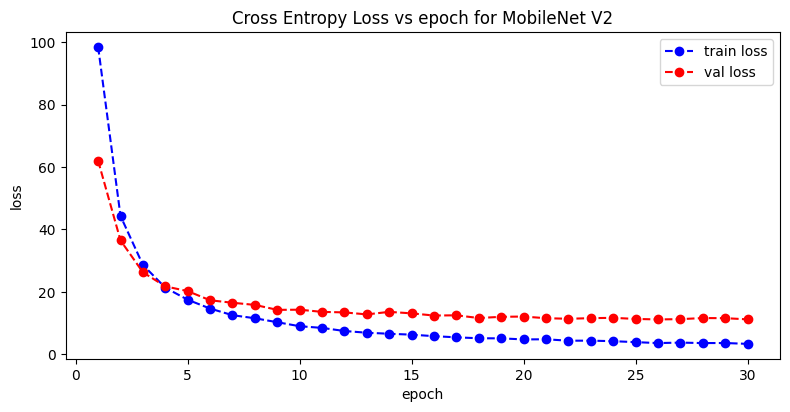

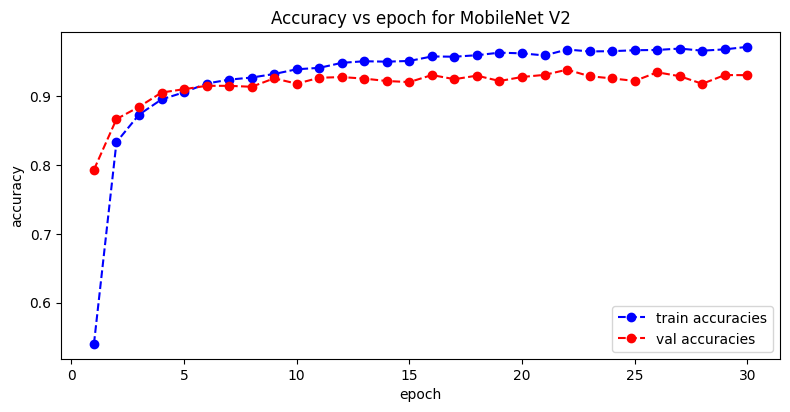

In [18]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for MobileNet V2",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for MobileNet V2",



)

## Testing MoblieNet V2 on Train, Val, Test Datasets

In [19]:
train_loss, train_accuracy, train_preds, train_labels = test(



    model=mobilenet_model, test_loader=train_loader, criterion=criterion, device=device



)



print("Train Data:")



print(f"loss= {np.round(train_loss, 3)}, accuracy= {np.round(train_accuracy, 3)}")











val_loss, val_accuracy, val_preds, val_labels = test(



    model=mobilenet_model, test_loader=val_loader, criterion=criterion, device=device



)



print("Val Data:")



print(f"loss= {np.round(val_loss, 3)}, accuracy= {np.round(val_accuracy, 3)}")











test_loss, test_accuracy, test_preds, test_labels = test(



    model=mobilenet_model, test_loader=test_loader, criterion=criterion, device=device



)



print("Test Data:")



print(f"loss= {np.round(test_loss, 3)}, accuracy= {np.round(test_accuracy, 3)}")

Train Data:
loss= 1.7, accuracy= 0.986
Val Data:
loss= 11.323, accuracy= 0.931
Test Data:
loss= 12.26, accuracy= 0.911


In [20]:
mobilenet_model.eval()







test_output = mobilenet_model(test_image)



top_classes, top_classes_idx = torch.topk(test_output, k=3, dim=1)



top_classes, top_classes_idx = top_classes.squeeze(), top_classes_idx.squeeze()







top_categories = classes[top_classes_idx.cpu()]



print(f"Top 3 categories: {top_categories}")

Top 3 categories: ['tree poppy' 'black-eyed susan' 'bougainvillea']


# Training VGG16

In [21]:
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)



vgg_model.classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s] 


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
num_features = vgg_model.classifier[6].in_features



vgg_model.classifier[6] = nn.Linear(



    in_features=num_features, out_features=num_classes, bias=True



)







for param in vgg_model.parameters():



    param.requires_grad = False







for param in vgg_model.classifier.parameters():



    param.requires_grad = True

In [23]:
vgg_model.to(device)



class_weights = class_weights.to(device)



criterion = nn.CrossEntropyLoss(weight=class_weights)



optimizer = optim.Adam(vgg_model.classifier.parameters())

In [24]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=vgg_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 82.297, Train acc: 0.504, Val loss: 40.383, Val acc: 0.664
Epoch 10/30, Train loss: 68.777, Train acc: 0.605, Val loss: 33.934, Val acc: 0.726
Epoch 15/30, Train loss: 62.299, Train acc: 0.653, Val loss: 31.6, Val acc: 0.759
Epoch 20/30, Train loss: 57.896, Train acc: 0.692, Val loss: 32.1, Val acc: 0.751
Epoch 25/30, Train loss: 55.069, Train acc: 0.701, Val loss: 33.694, Val acc: 0.758
Epoch 30/30, Train loss: 56.407, Train acc: 0.713, Val loss: 31.86, Val acc: 0.788
time: 1023.89 seconds


## Plotting Loss and Accuracy

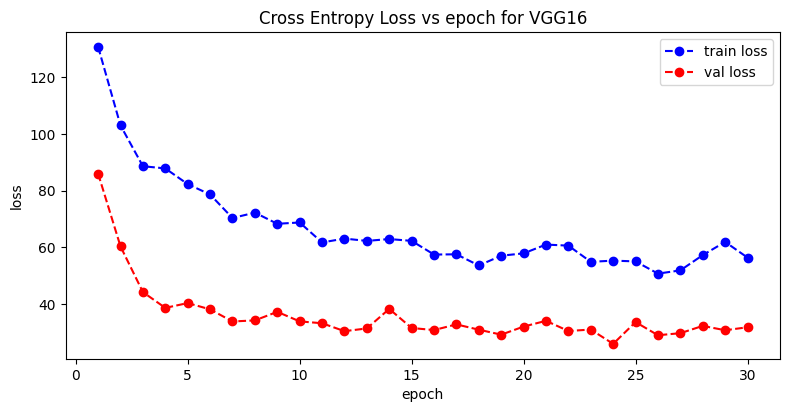

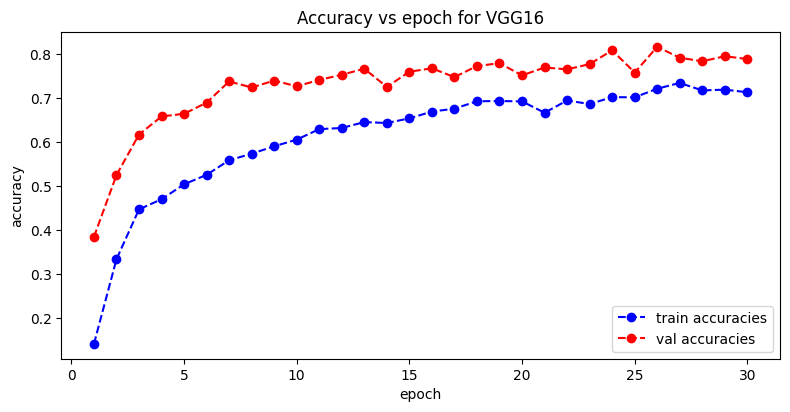

In [25]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for VGG16",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for VGG16",



)

### Testing VGG16 on Train, Val, Test Datasets

In [26]:
train_loss, train_accuracy, train_preds, train_labels = test(



    model=vgg_model, test_loader=train_loader, criterion=criterion, device=device



)



print("Train Data:")



print(f"loss= {np.round(train_loss, 3)}, accuracy= {np.round(train_accuracy, 3)}")







val_loss, val_accuracy, val_preds, val_labels = test(



    model=vgg_model, test_loader=val_loader, criterion=criterion, device=device



)



print("Val Data:")



print(f"loss= {np.round(val_loss, 3)}, accuracy= {np.round(val_accuracy, 3)}")







test_loss, test_accuracy, test_preds, test_labels = test(



    model=vgg_model, test_loader=test_loader, criterion=criterion, device=device



)



print("Test Data:")



print(f"loss= {np.round(test_loss, 3)}, accuracy= {np.round(test_accuracy, 3)}")

Train Data:
loss= 14.333, accuracy= 0.874
Val Data:
loss= 31.486, accuracy= 0.788
Test Data:
loss= 47.106, accuracy= 0.78


In [27]:
vgg_model.eval()







test_output = vgg_model(test_image)



top_classes, top_classes_idx = torch.topk(test_output, k=3, dim=1)



top_classes, top_classes_idx = top_classes.squeeze(), top_classes_idx.squeeze()







top_categories = classes[top_classes_idx.cpu()]



print(f"Top 3 categories: {top_categories}")

Top 3 categories: ['gaura' 'californian poppy' 'silverbush']


# Training ResNet50

In [28]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)



resnet_model.fc

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Linear(in_features=2048, out_features=1000, bias=True)

In [29]:
num_features = resnet_model.fc.in_features



resnet_model.fc = nn.Linear(



    in_features=num_features, out_features=num_classes, bias=True



)







for param in resnet_model.parameters():



    param.requires_grad = False







for param in resnet_model.fc.parameters():



    param.requires_grad = True

In [30]:
resnet_model.to(device)



class_weights = class_weights.to(device)



criterion = nn.CrossEntropyLoss(weight=class_weights)



optimizer = optim.Adam(resnet_model.fc.parameters())

In [31]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=resnet_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 13.743, Train acc: 0.949, Val loss: 21.072, Val acc: 0.907
Epoch 10/30, Train loss: 5.598, Train acc: 0.978, Val loss: 13.664, Val acc: 0.934
Epoch 15/30, Train loss: 3.091, Train acc: 0.989, Val loss: 11.189, Val acc: 0.939
Epoch 20/30, Train loss: 2.063, Train acc: 0.992, Val loss: 10.112, Val acc: 0.941
Epoch 25/30, Train loss: 1.496, Train acc: 0.994, Val loss: 8.934, Val acc: 0.944
Epoch 30/30, Train loss: 1.091, Train acc: 0.996, Val loss: 8.552, Val acc: 0.942
time: 955.13 seconds


### Plotting Loss and Accuracy

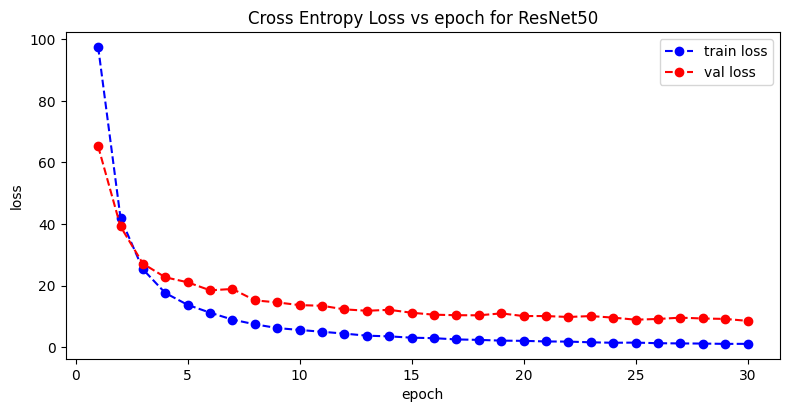

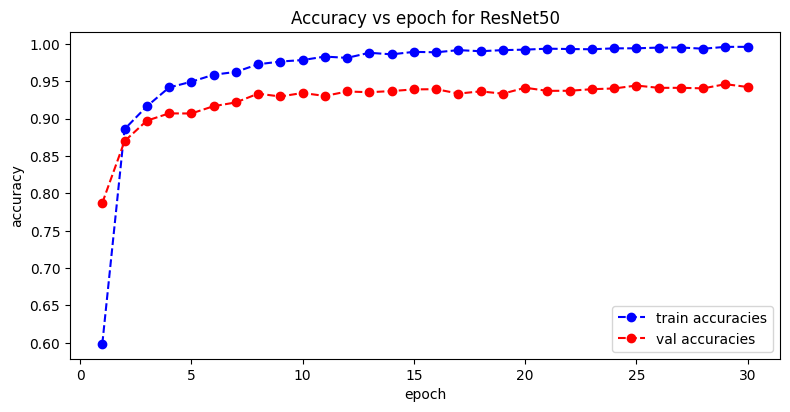

In [32]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for ResNet50",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for ResNet50",



)

### Testing ResNet50 on Train, Val, Test Datasets

In [33]:
train_loss, train_accuracy, train_preds, train_labels = test(



    model=resnet_model, test_loader=train_loader, criterion=criterion, device=device



)



print("Train Data:")



print(f"loss= {np.round(train_loss, 3)}, accuracy= {np.round(train_accuracy, 3)}")







val_loss, val_accuracy, val_preds, val_labels = test(



    model=resnet_model, test_loader=val_loader, criterion=criterion, device=device



)



print("Val Data:")



print(f"loss= {np.round(val_loss, 3)}, accuracy= {np.round(val_accuracy, 3)}")











test_loss, test_accuracy, test_preds, test_labels = test(



    model=resnet_model, test_loader=test_loader, criterion=criterion, device=device



)



print("Test Data:")



print(f"loss= {np.round(test_loss, 3)}, accuracy= {np.round(test_accuracy, 3)}")

Train Data:
loss= 0.719, accuracy= 0.998
Val Data:
loss= 8.516, accuracy= 0.942
Test Data:
loss= 9.381, accuracy= 0.946


In [34]:
resnet_model.eval()







test_output = resnet_model(test_image)



top_classes, top_classes_idx = torch.topk(test_output, k=3, dim=1)



top_classes, top_classes_idx = top_classes.squeeze(), top_classes_idx.squeeze()







top_categories = classes[top_classes_idx.cpu()]



print(f"Top 3 categories: {top_categories}")

Top 3 categories: ['californian poppy' 'lotus' 'corn poppy']


In [35]:
print('MobileNet V2:')

print(f"number of parameters= {get_num_parameters(mobilenet_model, mode='complete')}")

print(f"number of learnable parameters= {get_num_parameters(mobilenet_model, mode='learnable')}")



print('VGG16:')

print(f"number of parameters= {get_num_parameters(vgg_model, mode='complete')}")

print(f"number of learnable parameters= {get_num_parameters(vgg_model, mode='learnable')}")



print('ResNet50:')

print(f"number of parameters= {get_num_parameters(resnet_model, mode='complete')}")

print(f"number of learnable parameters= {get_num_parameters(resnet_model, mode='learnable')}")

MobileNet V2:
number of parameters= 2354534
number of learnable parameters= 130662
VGG16:
number of parameters= 134678438
number of learnable parameters= 119963750
ResNet50:
number of parameters= 23717030
number of learnable parameters= 208998


Test Accuracies:

* MobileNet V2: 93.1%

* VGG16: 78.8%

* ResNet50: 94.5%



<b>ResNet50</b> has the highest accuracy.

# Training MobileNet V2 with random weights

In [36]:
mobilenet_random_model = mobilenet_v2(weights=None)



mobilenet_random_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [37]:
num_features = mobilenet_random_model.classifier[1].in_features



mobilenet_random_model.classifier[1] = nn.Linear(



    in_features=num_features, out_features=num_classes, bias=True



)







for param in mobilenet_random_model.parameters():



    param.requires_grad = True

In [38]:
mobilenet_random_model.to(device)



class_weights = class_weights.to(device)



criterion = nn.CrossEntropyLoss(weight=class_weights)



optimizer = optim.Adam(mobilenet_random_model.parameters())

In [39]:
start_time = time.time()



epochs = 30







train_losses, train_accuracies, validation_losses, validation_accuracies = train(



    model=mobilenet_random_model,



    train_loader=train_loader,



    val_loader=val_loader,



    optimizer=optimizer,



    criterion=criterion,



    device=device,



    epochs=epochs,



    log=True,



)







end_time = time.time()



print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 98.517, Train acc: 0.186, Val loss: 97.304, Val acc: 0.228
Epoch 10/30, Train loss: 66.504, Train acc: 0.398, Val loss: 66.069, Val acc: 0.404
Epoch 15/30, Train loss: 44.086, Train acc: 0.569, Val loss: 44.813, Val acc: 0.597
Epoch 20/30, Train loss: 30.884, Train acc: 0.688, Val loss: 37.4, Val acc: 0.655
Epoch 25/30, Train loss: 24.16, Train acc: 0.753, Val loss: 34.624, Val acc: 0.695
Epoch 30/30, Train loss: 19.23, Train acc: 0.784, Val loss: 33.804, Val acc: 0.715
time: 983.71 seconds


### Plotting Loss and Accuracy

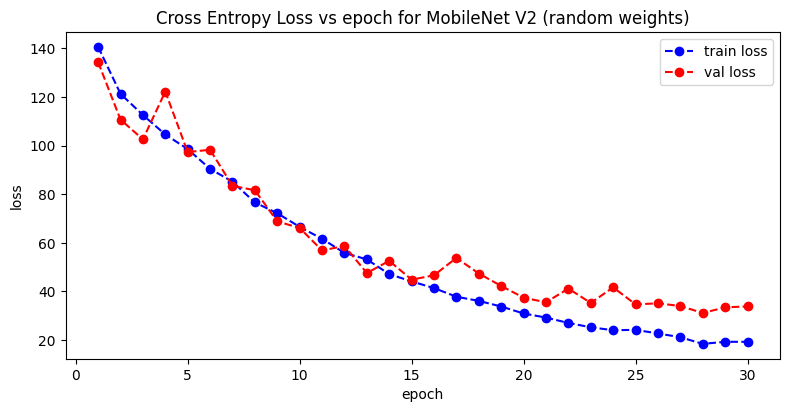

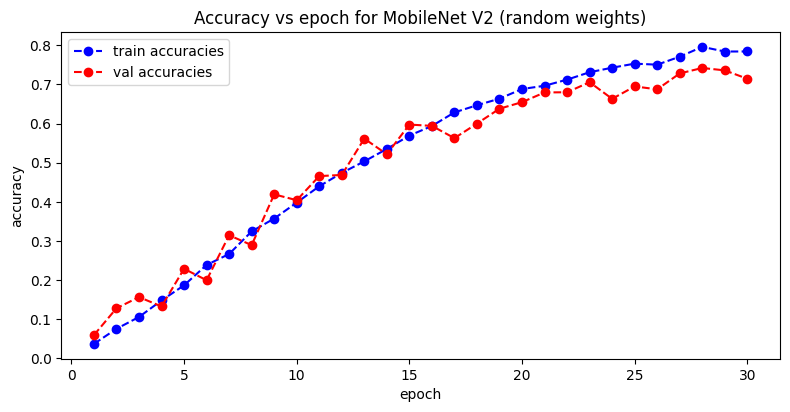

In [40]:
plot_loss(



    train_losses,



    validation_losses,



    epochs=epochs,



    title="Cross Entropy Loss vs epoch for MobileNet V2 (random weights)",



)



plot_acc(



    train_accuracies,



    validation_accuracies,



    epochs=epochs,



    title="Accuracy vs epoch for MobileNet V2 (random weights)",



)

## Testing MoblieNet V2 (random weights) on Train, Val, Test Datasets

In [41]:
train_loss, train_accuracy, train_preds, train_labels = test(



    model=mobilenet_random_model,



    test_loader=train_loader,



    criterion=criterion,



    device=device,



)



print("Train Data:")



print(f"loss= {np.round(train_loss, 3)}, accuracy= {np.round(train_accuracy, 3)}")











val_loss, val_accuracy, val_preds, val_labels = test(



    model=mobilenet_random_model,



    test_loader=val_loader,



    criterion=criterion,



    device=device,



)



print("Val Data:")



print(f"loss= {np.round(val_loss, 3)}, accuracy= {np.round(val_accuracy, 3)}")











test_loss, test_accuracy, test_preds, test_labels = test(



    model=mobilenet_random_model,



    test_loader=test_loader,



    criterion=criterion,



    device=device,



)



print("Test Data:")



print(f"loss= {np.round(test_loss, 3)}, accuracy= {np.round(test_accuracy, 3)}")

Train Data:
loss= 15.554, accuracy= 0.825
Val Data:
loss= 33.679, accuracy= 0.715
Test Data:
loss= 37.268, accuracy= 0.694


In [42]:
mobilenet_random_model.eval()







test_output = mobilenet_random_model(test_image)



top_classes, top_classes_idx = torch.topk(test_output, k=3, dim=1)



top_classes, top_classes_idx = top_classes.squeeze(), top_classes_idx.squeeze()







top_categories = classes[top_classes_idx.cpu()]



print(f"Top 3 categories: {top_categories}")

Top 3 categories: ['hibiscus' 'poinsettia' 'gaura']
